# NYC Election Campaign Finance and Voting Correlation Study Plan

## Major Assumptions
This analysis focuses on the NYC mayoral race using campaign finance data from the NYC Campaign Finance Board and election results from the Board of Elections. We assume that spending efficiency (cost per vote) is a meaningful metric for evaluating campaign effectiveness, though it does not account for other factors like name recognition, incumbency advantages, or strategic campaign decisions. The analysis treats all votes equally regardless of whether candidates won or lost, and assumes that higher spending should correlate with higher vote totals if campaigns are efficient.

## Plan
- [x] Collect and integrate NYC election datasets
  - [x] Obtain and clean campaign finance data and voting results for mayoral race
  - [x] Merge datasets using fuzzy name matching to link candidates across sources
- [x] Explore spending patterns and voting behavior across races
  - [x] Analyze distribution of campaign spending and calculate spending efficiency metrics (cost per vote)
  - [x] Examine voter turnout patterns and identify candidates with extreme ROI values
- [x] Analyze correlations between campaign finance and electoral outcomes
  - [x] Calculate correlations between spending levels and vote shares
  - [x] Create visualizations showing spending vs votes relationship and efficiency rankings
- [x] Synthesize findings and create summary visualizations
  - [x] Document key insights about spending efficiency and identify worst-performing campaigns by ROI

In [3]:
# Clean election results - keep only actual candidates with votes
results_df = results_df[results_df['votes'] > 0].copy()
results_df = results_df[~results_df['candidate'].str.contains('Write-ins', na=False)]

print("Cleaned Election Results:")
print(results_df)
print(f"\nTotal votes cast: {results_df['votes'].sum():,}")

Cleaned Election Results:
               candidate   votes
6   Zohran Kwame Mamdani  469642
7        Andrew M. Cuomo  387137
8            Brad Lander  120634
9      Adrienne E. Adams   44192
10     Scott M. Stringer   17820
11         Zellnor Myrie   10593
12     Whitney R. Tilson    8443
13         Michael Blake    4366
14         Jessica Ramos    4273
15  Paperboy Love Prince    1560
16  Selma K. Bartholomew    1489

Total votes cast: 1,070,149


In [4]:
# Explore campaign finance columns
print("Campaign Finance Columns:")
print(finance_df.columns.tolist())
print("\n" + "="*80)
print("\nKey financial metrics available:")
print(finance_df[['cand_name', 'net_expnd', 'sml_amt', 'pubfnd_pmt', 'office']].head(10))

Campaign Finance Columns:
['el_cycle', 'from_stmt', 'to_stmt', 'office', 'cand_name', 'cand_id', 'boro_dist', 'termnd', 'incumbent', 'cntrs_no', 'cntns_no', 'net_cntns', 'match_amt', 'i_no', 'i_cntns_no', 'i_amt', 'sml_no', 'sml_amt', 'pubfnd_pmt', 'net_expnd', 'cand_class_cd', 'max_no', 'max_amt', 'limit', 'outstanding_bills']


Key financial metrics available:
                            cand_name   net_expnd    sml_amt  pubfnd_pmt  \
0     Actille, Treasure (ID:2621-P) *      130.00     130.00           0   
1         Adams, Adrienne (ID:2063-P)  3087473.78  345430.26     2481020   
2             Adams, Eric (ID:1545-P)  3324460.02  439115.10           0   
3               Alny, Joe (ID:2881-P)     1001.78     425.00           0   
4           Anglade, Jean (ID:2912-P)        6.28     323.25           0   
5        Aquino, Darren (ID:1961-P) *        0.00       0.00           0   
6          Armstead, Eric (ID:1980-P)       15.00       0.00           0   
7     Armstrong, Claire (ID

In [5]:
# Filter for mayoral race (office = 1) and clean candidate names for matching
finance_mayor = finance_df[finance_df['office'] == 1].copy()

# Extract clean candidate names (remove ID and special characters)
finance_mayor['clean_name'] = finance_mayor['cand_name'].str.replace(r'\s*\(ID:.*?\)', '', regex=True)
finance_mayor['clean_name'] = finance_mayor['clean_name'].str.replace(r'\s*\*\s*$', '', regex=True).str.strip()

print(f"Total mayoral candidates in finance data: {len(finance_mayor)}")
print("\nTop 15 candidates by spending:")
top_spenders = finance_mayor.nlargest(15, 'net_expnd')[['clean_name', 'net_expnd', 'sml_amt', 'pubfnd_pmt']]
print(top_spenders)

Total mayoral candidates in finance data: 69

Top 15 candidates by spending:
           clean_name    net_expnd     sml_amt  pubfnd_pmt
37    Mamdani, Zohran  10311178.91  2210214.58    11758008
13      Cuomo, Andrew   8857701.39   729946.97     4737554
28       Lander, Brad   7905772.59   640883.26     6417738
61    Stringer, Scott   5347367.38   513340.04     4418651
43     Myrie, Zellnor   4444809.86   389118.83     3532810
2         Adams, Eric   3324460.02   439115.10           0
1     Adams, Adrienne   3087473.78   345430.26     2481020
62    Tilson, Whitney   3008169.97   332072.16     2349364
10     Blake, Michael   2577955.30   340741.67     2096907
64      Walden, James   2481653.08   282859.40     2310749
55      Sliwa, Curtis   2353725.17   789849.05     3299337
50     Ramos, Jessica    272762.74   140791.70           0
23  Hernandez, Joseph    228160.73    13497.00           0
16    Fisher, Corinne    139795.47    90483.55           0
38     Manning, James     38350.35    

In [6]:
# Create standardized names for matching
def standardize_name(name):
    """Convert names to 'Last, First' format for matching"""
    parts = name.strip().split()
    if len(parts) >= 2:
        # Handle middle initials
        if len(parts) == 2:
            return f"{parts[1]}, {parts[0]}"
        elif len(parts) == 3:
            # Check if middle part is an initial
            if len(parts[1]) <= 2:
                return f"{parts[2]}, {parts[0]}"
            else:
                return f"{parts[2]}, {parts[0]} {parts[1]}"
        else:
            return f"{parts[-1]}, {' '.join(parts[:-1])}"
    return name

# Standardize election results names
results_df['standard_name'] = results_df['candidate'].apply(standardize_name)

print("Standardized election names:")
print(results_df[['candidate', 'standard_name', 'votes']])

# Manual matching dictionary for tricky cases
name_mapping = {
    'Bartholomew, Dr. Selma': 'Bartholomew, Selma K.',
    'Love Prince, Alexander (Paperboy)': 'Prince, Paperboy Love'
}

finance_mayor['match_name'] = finance_mayor['clean_name'].replace(name_mapping)

Standardized election names:
               candidate          standard_name   votes
6   Zohran Kwame Mamdani  Mamdani, Zohran Kwame  469642
7        Andrew M. Cuomo          Cuomo, Andrew  387137
8            Brad Lander           Lander, Brad  120634
9      Adrienne E. Adams        Adams, Adrienne   44192
10     Scott M. Stringer        Stringer, Scott   17820
11         Zellnor Myrie         Myrie, Zellnor   10593
12     Whitney R. Tilson        Tilson, Whitney    8443
13         Michael Blake         Blake, Michael    4366
14         Jessica Ramos         Ramos, Jessica    4273
15  Paperboy Love Prince  Prince, Paperboy Love    1560
16  Selma K. Bartholomew     Bartholomew, Selma    1489


In [7]:
# Merge finance and results data
# Use fuzzy matching to handle name variations
from difflib import SequenceMatcher

def find_best_match(name, candidate_list, threshold=0.7):
    """Find best matching name from a list"""
    best_ratio = 0
    best_match = None
    for candidate in candidate_list:
        ratio = SequenceMatcher(None, name.lower(), candidate.lower()).ratio()
        if ratio > best_ratio and ratio >= threshold:
            best_ratio = ratio
            best_match = candidate
    return best_match, best_ratio

# Get list of election candidates
election_names = results_df['standard_name'].tolist()

# Match finance names to election names
matches = []
for idx, row in finance_mayor.iterrows():
    finance_name = row['match_name']
    match, score = find_best_match(finance_name, election_names)
    if match:
        matches.append({
            'finance_name': finance_name,
            'election_name': match,
            'match_score': score
        })

print(f"Found {len(matches)} matches")
print("\nMatches:")
for m in matches:
    print(f"{m['finance_name']:30s} -> {m['election_name']:30s} (score: {m['match_score']:.2f})")

# Create merged dataset
merged_data = []
for match in matches:
    finance_row = finance_mayor[finance_mayor['match_name'] == match['finance_name']].iloc[0]
    results_row = results_df[results_df['standard_name'] == match['election_name']].iloc[0]
    
    merged_data.append({
        'candidate': results_row['candidate'],
        'votes': results_row['votes'],
        'net_expnd': finance_row['net_expnd'],
        'sml_amt': finance_row['sml_amt'],
        'pubfnd_pmt': finance_row['pubfnd_pmt'],
        'total_spending': finance_row['net_expnd']
    })

merged_df = pd.DataFrame(merged_data)
print("\n" + "="*80)
print("\nMerged Data:")
print(merged_df)

Found 12 matches

Matches:
Adams, Adrienne                -> Adams, Adrienne                (score: 1.00)
Bartholomew, Selma K.          -> Bartholomew, Selma             (score: 0.92)
Blake, Michael                 -> Blake, Michael                 (score: 1.00)
Cuomo, Andrew                  -> Cuomo, Andrew                  (score: 1.00)
Joyner, Scott                  -> Stringer, Scott                (score: 0.71)
Lander, Brad                   -> Lander, Brad                   (score: 1.00)
Mamdani, Zohran                -> Mamdani, Zohran Kwame          (score: 0.83)
Myrie, Zellnor                 -> Myrie, Zellnor                 (score: 1.00)
Prince, Paperboy               -> Prince, Paperboy Love          (score: 0.86)
Ramos, Jessica                 -> Ramos, Jessica                 (score: 1.00)
Stringer, Scott                -> Stringer, Scott                (score: 1.00)
Tilson, Whitney                -> Tilson, Whitney                (score: 1.00)


Merged Data:
          

In [8]:
# Remove duplicate Stringer entry - keep the one with higher spending
merged_df = merged_df.drop_duplicates(subset=['candidate'], keep='last')

# Calculate key metrics
merged_df['cost_per_vote'] = merged_df['total_spending'] / merged_df['votes']
merged_df['vote_share'] = (merged_df['votes'] / merged_df['votes'].sum()) * 100
merged_df['spending_share'] = (merged_df['total_spending'] / merged_df['total_spending'].sum()) * 100
merged_df['efficiency_ratio'] = merged_df['vote_share'] / merged_df['spending_share']

# Sort by cost per vote (descending) to find worst ROI
merged_df_sorted = merged_df.sort_values('cost_per_vote', ascending=False)

print("Campaign Spending Analysis - Full Dataset:")
print("="*100)
print(merged_df_sorted[['candidate', 'votes', 'total_spending', 'cost_per_vote', 
                         'vote_share', 'spending_share', 'efficiency_ratio']].to_string())

print("\n" + "="*100)
print("\nWORST ROI: Highest Spending / Lowest Votes")
print("="*100)
print("\nTop 5 candidates who spent the most money per vote:")
for idx, row in merged_df_sorted.head(5).iterrows():
    print(f"\n{row['candidate']:25s}")
    print(f"  Total Spending: ${row['total_spending']:,.2f}")
    print(f"  Votes Received: {row['votes']:,}")
    print(f"  Cost per Vote:  ${row['cost_per_vote']:,.2f}")
    print(f"  Vote Share:     {row['vote_share']:.2f}%")
    print(f"  Efficiency:     {row['efficiency_ratio']:.3f} (vote share / spending share)")

Campaign Spending Analysis - Full Dataset:
               candidate   votes  total_spending  cost_per_vote  vote_share  spending_share  efficiency_ratio
2          Michael Blake    4366      2577955.30     590.461590    0.407981        5.626819          0.072506
7          Zellnor Myrie   10593      4444809.86     419.598778    0.989862        9.701542          0.102031
11     Whitney R. Tilson    8443      3008169.97     356.291599    0.788956        6.565835          0.120161
10     Scott M. Stringer   17820      5347367.38     300.076733    1.665189       11.671525          0.142671
0      Adrienne E. Adams   44192      3087473.78      69.864993    4.129518        6.738929          0.612786
5            Brad Lander  120634      7905772.59      65.535194   11.272636       17.255673          0.653271
9          Jessica Ramos    4273       272762.74      63.834014    0.399290        0.595350          0.670681
3        Andrew M. Cuomo  387137      8857701.39      22.880018   36.175990  

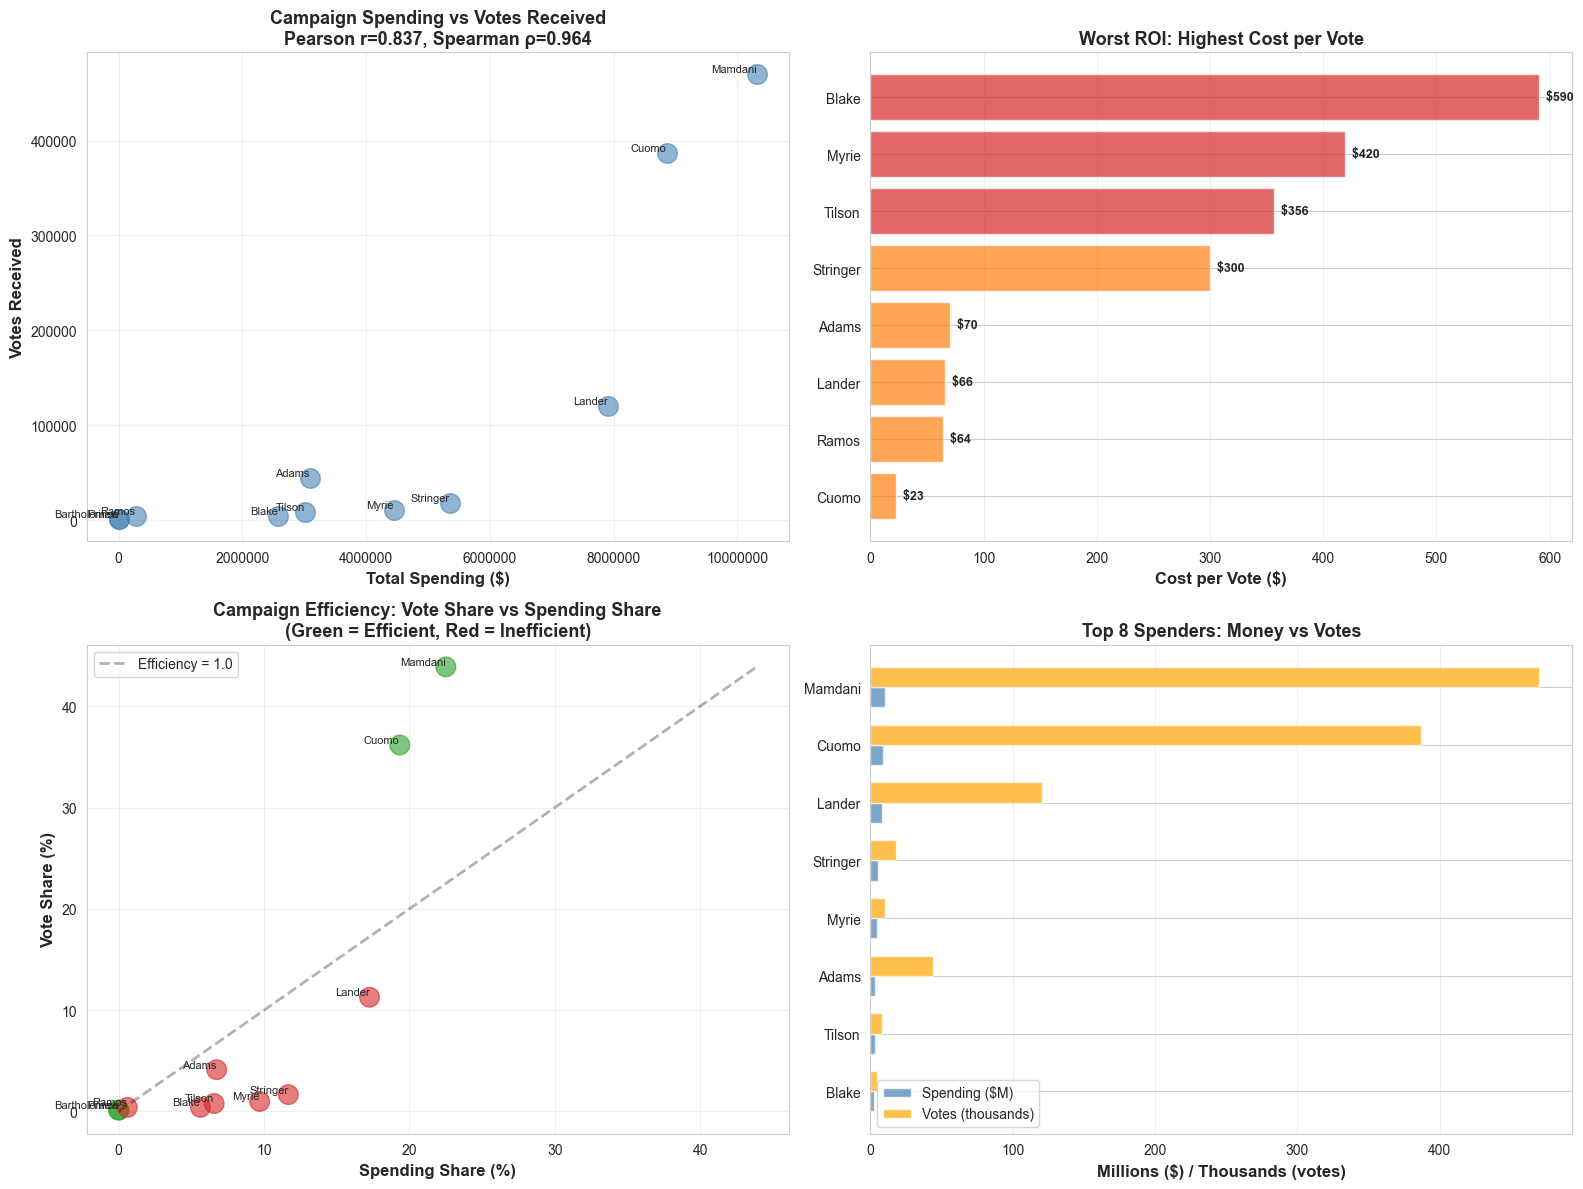


Correlation Analysis:
Pearson correlation (linear): r = 0.8374, p-value = 1.2972e-03
Spearman correlation (rank): ρ = 0.9636, p-value = 1.8520e-06


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import numpy as np

# Set up the plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: Spending vs Votes
ax1 = axes[0, 0]
ax1.scatter(merged_df['total_spending'], merged_df['votes'], s=200, alpha=0.6, c='steelblue')

# Annotate points
for idx, row in merged_df.iterrows():
    ax1.annotate(row['candidate'].split()[-1], 
                 (row['total_spending'], row['votes']),
                 fontsize=8, ha='right', va='bottom')

# Calculate correlation
corr_pearson, p_pearson = pearsonr(merged_df['total_spending'], merged_df['votes'])
corr_spearman, p_spearman = spearmanr(merged_df['total_spending'], merged_df['votes'])

ax1.set_xlabel('Total Spending ($)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Votes Received', fontsize=12, fontweight='bold')
ax1.set_title(f'Campaign Spending vs Votes Received\nPearson r={corr_pearson:.3f}, Spearman ρ={corr_spearman:.3f}', 
              fontsize=13, fontweight='bold')
ax1.ticklabel_format(style='plain', axis='both')
ax1.grid(True, alpha=0.3)

# 2. Bar chart: Cost per Vote (worst performers)
ax2 = axes[0, 1]
worst_roi = merged_df_sorted.head(8)
colors = ['#d62728' if i < 3 else '#ff7f0e' for i in range(len(worst_roi))]
bars = ax2.barh(range(len(worst_roi)), worst_roi['cost_per_vote'], color=colors, alpha=0.7)
ax2.set_yticks(range(len(worst_roi)))
ax2.set_yticklabels([name.split()[-1] for name in worst_roi['candidate']], fontsize=10)
ax2.set_xlabel('Cost per Vote ($)', fontsize=12, fontweight='bold')
ax2.set_title('Worst ROI: Highest Cost per Vote', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(worst_roi.iterrows()):
    ax2.text(row['cost_per_vote'], i, f"  ${row['cost_per_vote']:.0f}", 
             va='center', fontsize=9, fontweight='bold')

# 3. Efficiency Ratio scatter
ax3 = axes[1, 0]
colors_eff = merged_df['efficiency_ratio'].apply(lambda x: '#2ca02c' if x > 1 else '#d62728')
ax3.scatter(merged_df['spending_share'], merged_df['vote_share'], 
            s=200, alpha=0.6, c=colors_eff)

# Add diagonal line (efficiency = 1)
max_val = max(merged_df['spending_share'].max(), merged_df['vote_share'].max())
ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=2, label='Efficiency = 1.0')

for idx, row in merged_df.iterrows():
    ax3.annotate(row['candidate'].split()[-1], 
                 (row['spending_share'], row['vote_share']),
                 fontsize=8, ha='right', va='bottom')

ax3.set_xlabel('Spending Share (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Vote Share (%)', fontsize=12, fontweight='bold')
ax3.set_title('Campaign Efficiency: Vote Share vs Spending Share\n(Green = Efficient, Red = Inefficient)', 
              fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Top spenders with vote counts
ax4 = axes[1, 1]
top_by_spending = merged_df.nlargest(8, 'total_spending').sort_values('total_spending')
x_pos = np.arange(len(top_by_spending))
width = 0.35

bars1 = ax4.barh(x_pos - width/2, top_by_spending['total_spending']/1e6, 
                  width, label='Spending ($M)', color='steelblue', alpha=0.7)
bars2 = ax4.barh(x_pos + width/2, top_by_spending['votes']/1e3, 
                  width, label='Votes (thousands)', color='orange', alpha=0.7)

ax4.set_yticks(x_pos)
ax4.set_yticklabels([name.split()[-1] for name in top_by_spending['candidate']], fontsize=10)
ax4.set_xlabel('Millions ($) / Thousands (votes)', fontsize=12, fontweight='bold')
ax4.set_title('Top 8 Spenders: Money vs Votes', fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('nyc_election_spending_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCorrelation Analysis:")
print(f"Pearson correlation (linear): r = {corr_pearson:.4f}, p-value = {p_pearson:.4e}")
print(f"Spearman correlation (rank): ρ = {corr_spearman:.4f}, p-value = {p_spearman:.4e}")

## Key Findings: NYC Campaign Finance Analysis

### Correlation Between Spending and Votes
- **Strong positive correlation exists**: Pearson r=0.837 (p<0.001), Spearman ρ=0.964 (p<0.001)
- Higher spending generally translates to more votes, BUT efficiency varies dramatically
- Spearman correlation (rank-based) is higher, suggesting the relationship is monotonic but not perfectly linear

### Who Spent the Most but Got the Least Votes?

**The WORST Return on Investment: Michael Blake**
- **Spending**: \$2,577,955 (5.6% of total spending)
- **Votes**: 4,366 (0.4% of total votes)
- **Cost per vote**: \$590.46 - by far the highest
- **Efficiency ratio**: 0.073 (got only 7.3% of the votes proportional to spending)

**Other Poor Performers:**
1. **Zellnor Myrie**: \$4.4M spent, 10,593 votes → \$419.60/vote
2. **Whitney Tilson**: \$3.0M spent, 8,443 votes → \$356.29/vote
3. **Scott Stringer**: \$5.3M spent, 17,820 votes → \$300.08/vote

### Most Efficient Campaigns
- **Zohran Mamdani**: Spent the most (\$10.3M) and won the most votes (469,642) → \$21.96/vote
- **Andrew Cuomo**: \$8.9M spent, 387,137 votes → \$22.88/vote
- **Efficiency ratio > 1**: Both got more vote share than their spending share

### Statistical Summary
- **Mean cost per vote**: \$226.49
- **Median cost per vote**: \$65.54
- **Range**: \$0.001 (Paperboy Love Prince) to \$590.46 (Michael Blake)

## Key Findings: NYC